In [2]:
import os
import pandas as pd
import numpy as np
    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split


output_dir = os.path.join(".", "output_dance")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
combined_tensor = torch.from_numpy(combined_arr)

(10000, 1000, 10)


In [5]:

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 512  # modify as needed
hidden_dim2 = 256  # modify as needed
hidden_dim3 = 24  # modify as needed
latent_dims = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 400  # modify as needed
beta = 0.2
    

Train epoch:0 with previous loss 2438254.0
Train epoch:1 with previous loss 2261795.25
Train epoch:2 with previous loss 2188500.25
Train epoch:3 with previous loss 2152290.0
Train epoch:4 with previous loss 2139141.0
Train epoch:5 with previous loss 2132461.25
Train epoch:6 with previous loss 2117165.0
Train epoch:7 with previous loss 2095200.125
Train epoch:8 with previous loss 2100747.75
Train epoch:9 with previous loss 2089036.5
Train epoch:10 with previous loss 2075741.375
Train epoch:11 with previous loss 2092411.625
Train epoch:12 with previous loss 2083792.375
Train epoch:13 with previous loss 2079747.625
Train epoch:14 with previous loss 2096092.375
Train epoch:15 with previous loss 2083277.625
Train epoch:16 with previous loss 2066483.625
Train epoch:17 with previous loss 2075747.625
Train epoch:18 with previous loss 2102474.5
Train epoch:19 with previous loss 2057350.125


/var/folders/dl/61k_wctj56gfxw96rry1rsgw0000gn/T/ipykernel_45114/21906588.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], cmap='tab10')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x10 and 10000x512)

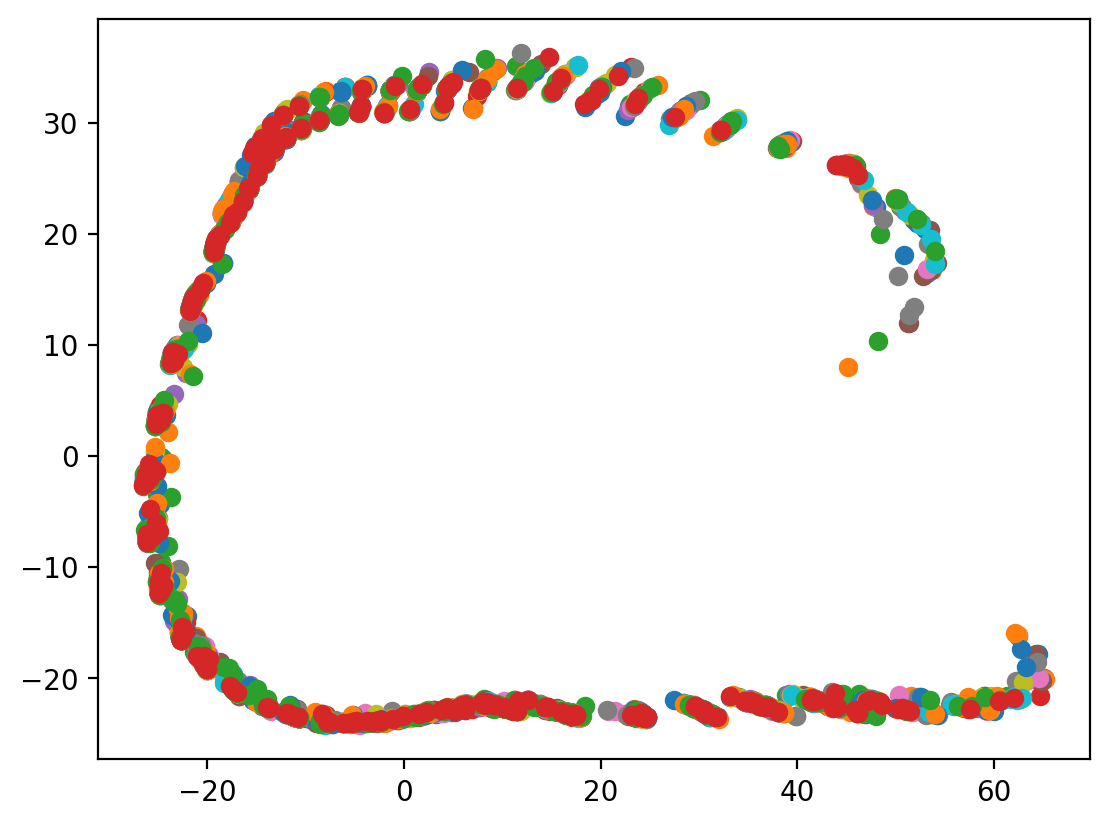

In [16]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

def plot_latent(autoencoder, data, num_batches=100):
    for i, x in enumerate(data):
        if isinstance(x, list):
            x = x[0]  # If x is a list, get the first element (assuming it contains the data tensor)
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

            
            
class VariationalEncoder(nn.Module):
    def __init__(self, input_dims, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.input_dims = input_dims
        self.latent_dims = latent_dims

        self.linear1 = nn.Linear(self.input_dims, 512)
        self.linear2 = nn.Linear(512, 256)  # Reduce the dimensionality further
        self.linear3_mu = nn.Linear(256, self.latent_dims)  # Output mu of the latent space
        self.linear3_logvar = nn.Linear(256, self.latent_dims)  # Output logvar of the latent space

        self.N = torch.distributions.Normal(0, 1)
        
        self.kl = 0

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the batch dimension
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.linear3_mu(x)
        logvar = self.linear3_logvar(x)

        # Re-parameterization trick!
        z = self.reparameterize(mu, logvar)

        # Kullback-Leibler Divergence
        self.kl = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar, dim=1).mean()

        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


class Decoder(nn.Module):
    def __init__(self, latent_dims, combined_tensor):
        super(Decoder, self).__init__()
        self.latent_dims = latent_dims
        self.combined_tensor = combined_tensor

        self.linear1 = nn.Linear(self.latent_dims, 512)
        self.linear2 = nn.Linear(512, np.prod(self.get_output_shape()))

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.view(-1, *self.get_output_shape())

    def get_output_shape(self):
        return self.combined_tensor.shape[1:]  # Excluding the batch dimension

    
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_dims, combined_tensor):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_shape, latent_dims)
        self.decoder = Decoder(latent_dims, combined_tensor)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    
def train(autoencoder, data_loader, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for batch in data_loader:  # Loop over the batches
            x = batch[0]  # Move the data to the CPU (if working with CPU)

            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

        print(f'Train epoch:{epoch} with previous loss {loss}')

    return autoencoder



# # Assuming combined_tensor is your data
# data_tensor = combined_tensor[0].float()  # Extract the data tensor
# data_tensor = data_tensor.float()  # Convert the tensor to float32

# # Inspect the shape of data_tensor
# print(data_tensor.shape)

# # Calculate the input_dims value if data_tensor has the correct shape
# if len(data_tensor.shape) == 3:  # Assuming data_tensor has shape (batch_size, height, width)
#     input_dims = data_tensor.shape[1] * data_tensor.shape[2]
# else:
#     # Handle the situation if data_tensor has a different shape than expected
#     raise ValueError("data_tensor has unexpected shape. Please adjust input_dims calculation accordingly.")

# # Create a DataLoader for the combined_tensor
# batch_size = 64  # You can adjust this to your desired batch size
# combined_data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

# # Assuming latent_dims is defined
# vae = VariationalAutoencoder(input_dims, latent_dims, combined_tensor)
# vae = train(vae, train_loader)
# plot_latent(vae, train_loader)

# plot_latent(vae, combined_data_loader)  # Pass the DataLoader here



# -----------------------

# Assuming combined_tensor is your data
data_tensor = combined_tensor[0].float()  # Extract the data tensor
input_dims = combined_tensor.shape[1]* combined_tensor.shape[2]  # Number of features per sample
vae = VariationalAutoencoder(input_dims, latent_dims, combined_tensor)
vae = train(vae, train_loader)
plot_latent(vae, train_loader)

# Create a DataLoader for the combined_tensor
batch_size = 64  # You can adjust this to your desired batch size
combined_data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

plot_latent(vae, combined_data_loader)  # Pass the DataLoader here
